In [32]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import BatchNormalization
import tensorflow as tf
import numpy as np
from matplotlib import pyplot

In [15]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
    # define the discriminator model
    model = Sequential()
    # downsample to 14x14
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=(28,28,3)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 7x7
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    # classify
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [16]:
# define the standalone generator model
def define_generator(latent_dim):
    # define the generator model
    model = Sequential()
    # foundation for 7x7 image
    n_nodes = 64 * 7 * 7
    model.add(Dense(n_nodes, input_dim=100))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 64)))
    # upsample to 14x14
    model.add(Conv2DTranspose(64, (3,3), strides=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 28x28
    model.add(Conv2DTranspose(64, (3,3), strides=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model

In [17]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [18]:
def parse_image(file_name, index):
    image = tf.io.read_file(file_name)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32).numpy()
    return image

In [19]:
def load_real_samples(path):
    folder_list = tf.io.gfile.listdir(path)
    images = []
    for i, folder in enumerate(folder_list):
        #if i == 2:
        #    return np.array(images)
        file_list = tf.io.gfile.listdir(path + folder)
        for file_name in file_list:
            image = parse_image(path + folder + file_name, i)
            images.append(image)
    return np.array(images)

In [20]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # select images
    X = dataset[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return X, y

In [21]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [22]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = zeros((n_samples, 1))
    return X, y

In [23]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        d_loss1 = 0.0
        d_loss2 = 0.0
        g_loss = 0.0
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
        print('>%d, d1=%.3f, d2=%.3f g=%.3f' %
            (i+1, d_loss1, d_loss2, g_loss))
    g_model.save('generator.h5')
    return g_model

In [24]:
latent_dim = 100

d_model = define_discriminator()

"""
tf.keras.utils.plot_model(
    d_model,
    to_file="discriminator.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)
"""

g_model = define_generator(latent_dim)

"""
tf.keras.utils.plot_model(
    g_model,
    to_file="generator.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)
"""
gan_model = define_gan(g_model, d_model)

In [25]:
dataset = load_real_samples('gs://emanuel-aa-sandbox/hackathon-training-data-generation-small/')

In [28]:
model = train(g_model, d_model, gan_model, dataset, latent_dim)

/Users/batot/anaconda3/envs/hackaton/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, d1=0.163, d2=0.603 g=0.957
>2, d1=0.103, d2=0.446 g=1.346
>3, d1=0.164, d2=0.262 g=1.669
>4, d1=0.123, d2=0.229 g=1.741
>5, d1=0.098, d2=0.139 g=2.487
>6, d1=0.068, d2=0.090 g=2.764
>7, d1=0.040, d2=0.046 g=3.278
>8, d1=0.035, d2=0.026 g=3.369
>9, d1=0.012, d2=0.019 g=3.360
>10, d1=0.010, d2=0.014 g=3.031
>11, d1=0.005, d2=0.012 g=3.347
>12, d1=0.007, d2=0.016 g=3.232
>13, d1=0.007, d2=0.025 g=3.154
>14, d1=0.034, d2=0.031 g=2.951
>15, d1=0.024, d2=0.025 g=3.425
>16, d1=0.015, d2=0.010 g=3.272
>17, d1=0.004, d2=0.006 g=4.309
>18, d1=0.004, d2=0.016 g=4.014
>19, d1=0.008, d2=0.011 g=4.457
>20, d1=0.031, d2=0.011 g=4.504
>21, d1=0.056, d2=0.005 g=4.916
>22, d1=0.249, d2=0.053 g=3.304
>23, d1=0.008, d2=0.007 g=4.421
>24, d1=0.005, d2=0.009 g=4.882
>25, d1=0.012, d2=0.016 g=4.998
>26, d1=0.025, d2=0.019 g=4.671
>27, d1=0.012, d2=0.016 g=4.947
>28, d1=0.037, d2=0.024 g=4.301
>29, d1=0.008, d2=0.010 g=5.037
>30, d1=0.008, d2=0.016 g=5.214
>31, d1=0.039, d2=0.027 g=4.166
>32, d1=0.016, d2

In [ ]:
from keras.models import load_model
model = load_model('generator.h5')

In [30]:
latent_points = generate_latent_points(100, 10)
predictions = model.predict(latent_points)

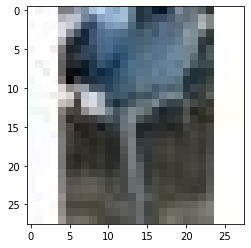

In [48]:
pyplot.imshow(dataset[3])

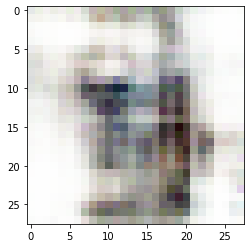

In [46]:
pyplot.imshow(predictions[9])

In [ ]:
import imageio
for i in range(100):
    imageio.imwrite('output/gan/output_' + str(i) + '.jpg', tf.image.convert_image_dtype(predictions[i], tf.uint8).numpy())